In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from transformers import GPT2Tokenizer
import torch

In [2]:
from dist_ir.executor import (
    CostModel,
    infer_types,
    PostTypeInferenceSimulator,
    Simulator,
    SequentialExecutor,
)
from dist_ir.importer import import_from_onnx
from dist_ir.ir import cpprint, Device, Topology, Value
from dist_ir.ir.type import Float32, Tensor
from dist_ir.transforms import gpt2_dhp_transform, filter_transform
from examples import gpt2

In [3]:
MODEL_PATH = "/lfs/1/keshav2/gpt2/model.onnx"
NETWORK_BANDWIDTH_Gbps = 200

In [4]:
def get_simulation(batch_size, dp_degree, hp_degree, pp_degree, num_microbatches, filter_set=None):
    topology = Topology()
    d0 = topology.add_device("gpu")
    function, input_data = gpt2.import_function_and_get_input_data(
        MODEL_PATH, batch_size=batch_size, default_device=d0
    )
    transformed_function, simulation = gpt2.simulate(
        function,
        input_data,
        topology,
        dp_degree,
        hp_degree,
        pp_degree,
        num_microbatches,
        filter_set
    )
    return transformed_function, simulation

In [5]:
def plot_live_memory(simulation, start_time=0, figsize=(10, 8)):
    world_size = len(simulation.live_memory)
    fig, axs = plt.subplots(world_size, sharex=True, sharey=False, figsize=figsize)
    devices = sorted(simulation.live_memory.keys(), key=lambda x: int(x.device_id))
    for i, device in enumerate(devices):
        x, y = zip(*simulation.live_memory[device])
        live_memory = defaultdict(lambda: 0)
        for x_, y_ in zip(x, y):
            if x_ * 1e3 >= start_time:
                live_memory[x_ * 1e3] = max(live_memory[x_ * 1e3], y_)
        x = sorted(live_memory.keys())
        y = [live_memory[x_] / (2.0**20) for x_ in x]
        if world_size == 1:
            axs.plot(x, y)
        else:
            axs[i].plot(x, y)
    plt.xlabel("Time (ms)")
    fig.text(0.075, 0.5, "MiB", va="center", rotation="vertical")

In [6]:
transformed_function, simulation = get_simulation(64, 1, 1, 1, 1, filter_set=set(["Send"]))
simulation.dump_chrome_trace("gpt2_single_device.json")

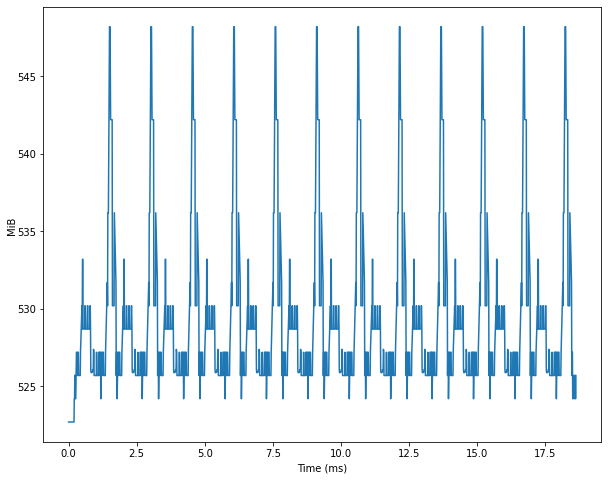

In [7]:
plot_live_memory(simulation)

In [8]:
transformed_function, simulation = get_simulation(
    64, 4, 1, 1, 1, filter_set=set(["Send", "MPIScatter", "MPIBroadcast"])
)
simulation.dump_chrome_trace("gpt2_dp=4_hp=1_pp=1_k=1.json")

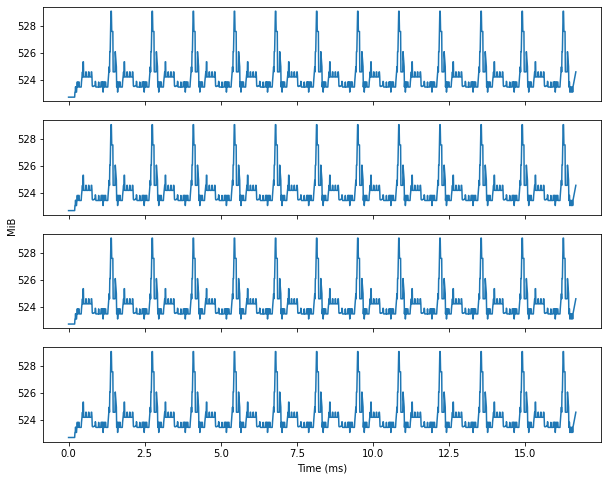

In [9]:
plot_live_memory(simulation)

In [10]:
transformed_function, simulation = get_simulation(
    64, 1, 1, 4, 4, filter_set=set(["Send"])
)
simulation.dump_chrome_trace("gpt2_dp=1_hp=1_pp=4_k=4.json")

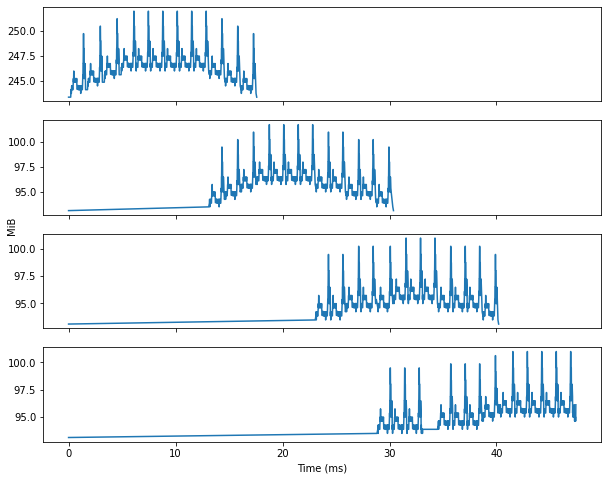

In [11]:
plot_live_memory(simulation)

In [12]:
transformed_function, simulation = get_simulation(
    64, 2, 1, 2, 4, filter_set=set(["Send", "MPIBroadcast", "MPIScatter"])
)
simulation.dump_chrome_trace("gpt2_dp=2_hp=1_pp=2_k=4.json")

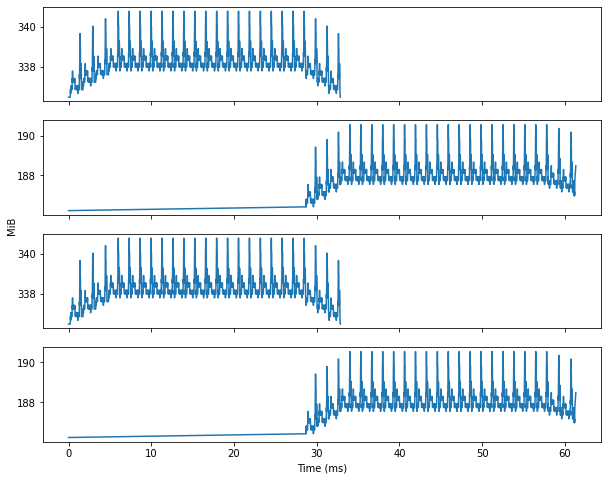

In [13]:
plot_live_memory(simulation)

In [14]:
transformed_function, simulation = get_simulation(
    64, 1, 4, 1, 1, filter_set=set(["Send", "MPIBroadcast", "MPIScatter"])
)
simulation.dump_chrome_trace("gpt2_dp=1_hp=4_pp=1_k=1.json")

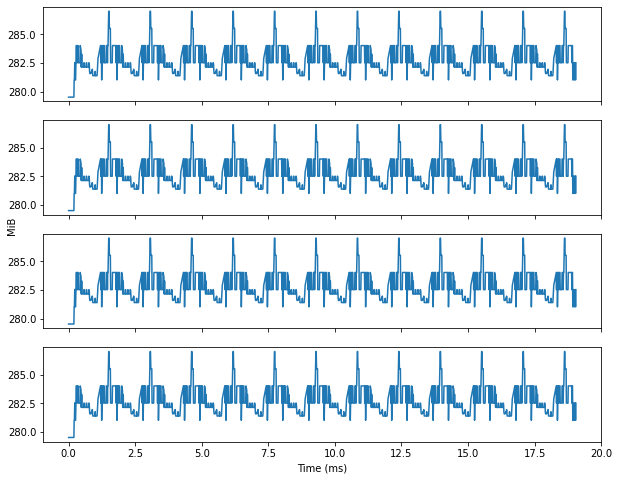

In [15]:
plot_live_memory(simulation)

In [16]:
transformed_function, simulation = get_simulation(
    64, 2, 2, 2, 8, filter_set=set(["Send", "MPIBroadcast", "MPIScatter"])
)
simulation.dump_chrome_trace("gpt2_dp=2_hp=2_pp=2_k=8.json")

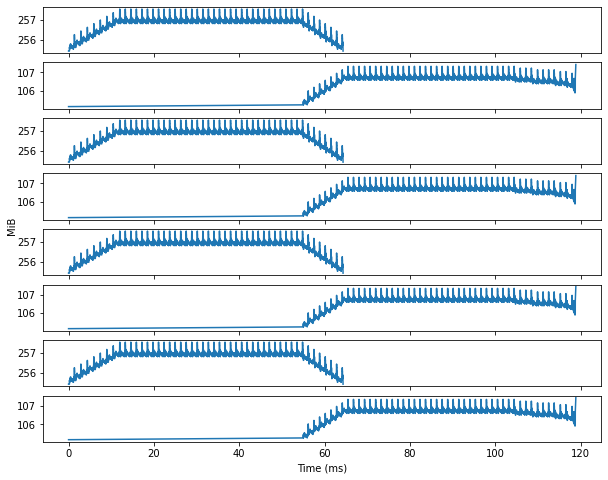

In [17]:
plot_live_memory(simulation)